# Parsing KEGG annotation tables for gene presence/absence

In [1]:
#imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob

In [2]:
#plotting imports
import seaborn as sns
import scipy.cluster
from scipy.cluster import hierarchy
from scipy.spatial import distance
from collections import defaultdict
from matplotlib.colors import rgb2hex
from matplotlib.colors import rgb2hex, colorConverter

In [3]:
nifH_meta = pd.read_csv("/vortexfs1/omics/alexander/lblum/tara_gene_finder/mag_analysis/outputs/nifH_brief_mags_metadata.csv")
#classification_y is GTDBTK taxonomy

In [4]:
koala_files = glob.glob("/vortexfs1/omics/alexander/lblum/tara_gene_finder/mag_analysis/kobra-annotation/output/kegg_table/*.tsv")
#set of KEGG annotation tables

In [5]:
#This is the color and taxonomy labels in order for the MAGs and genomes associated with nifH 
#This is purely for ordering.
bin_file = pd.read_csv("/vortexfs1/omics/alexander/lblum/tara_gene_finder/tree_building/nifH_magseqs_phylo/nifHwholegenome_order_heatmapcolors.csv")
bin_file= bin_file.iloc[:,:3]
bin_file.columns = ["bin_name", "c_code", "GTDBTK_taxa"]

In [6]:
color_dict = dict(zip(bin_file['bin_name'], bin_file['c_code']))
#stores the color codes for taxonomy groupings with keys representing bin names
#used for asthetic coloring of plots.

In [7]:
def create_x_labs(df):
    '''
    This function facilitates the creation of x labels, which are gene names for the presence/absence heatmaps.
    '''
    x_labs = []
    for kid in df.columns:
        x_lab = KEGG_dict[kid]
    
        x_labs.append(x_lab)
    return x_labs 

In [8]:
def create_y_labs(df):
    '''
    This function facilitates the creation of y labels, which are gene names for the presence/absence heatmaps.
    Specifically, it was used to create colored labels based on taxonomy.
    '''
    y_labs = []
    for b in df['bin_name']:
        y_lab = color_dict[b]
        
        y_labs.append(y_lab)
    return y_labs

In [9]:
#Creating data frame describing all the genes of interest by KEGG ID and gene name
complete_genes = pd.read_csv("/vortexfs1/omics/alexander/lblum/tara_gene_finder/mag_analysis/KEGG_gene_list/nifH_mags_complete_gene_list.txt", header = None, sep = '\t')
complete_genes.columns = ['KEGG', 'KEGG_definition', 'number']
complete_genes['KEGG_gene'] = complete_genes['KEGG_definition'].str[:4]
complete_genes['KEGG_long_gene'] = complete_genes['KEGG_definition'].str.split("\[").str[0]

In [10]:
#a list of the nitrogen genes
genes_of_interest = ['K02588','K02567','K15864', 'K04561', 'K02448','K00376','K00370','K03385','K15876']
nitrogen_genes = complete_genes.loc[complete_genes['KEGG'].isin(genes_of_interest)]

In [11]:
#connect KEGG ID number to the name of a gene for ease of interpretation.
KEGG_dict = {}
for index in complete_genes.index:
    number = complete_genes.loc[index, 'KEGG']
    KEGG_dict[number] = complete_genes.loc[index, 'KEGG_gene']

In [12]:
#this code is used to create data frames of counts for each of the genes among the KEGG tables.
koala_dict = {}
count_dict = {}
for koala in koala_files:
    koala_key = os.path.basename(koala).replace(".tsv","").replace(".kegg_table","")
    k_frame = pd.read_csv(koala, sep = '\t', error_bad_lines=False, header = None)
    k_frame = k_frame.iloc[1:,[0,2,3]]
    k_frame.columns = ['protein_id', "KEGG", "KEGG_definition"]
    k_frame= k_frame.dropna()
    k_frame['count'] = 1
    k_count =pd.DataFrame(k_frame.KEGG.value_counts())
    k_count.columns=[koala_key]
    koala_dict[koala_key] = k_frame
    count_dict[koala_key] = k_count

In [13]:
#compile all the count dfs into one df
master_count = pd.DataFrame()
for key, sub_df in count_dict.items():
    master_count = master_count.append(sub_df, sort=False)
    
master_count = master_count.fillna(0)

In [14]:
#sums counts
aggregate_counts = master_count.groupby(master_count.index).agg("max")

In [15]:
#create a master data table for presence and absence across all MAGs/references and genes of interest
count_df = aggregate_counts
gene_list = complete_genes['KEGG']
gene_counts = aggregate_counts.loc[aggregate_counts.index.isin(gene_list)]
gene_counts = gene_counts.T
gene_counts[gene_counts != 0] = 1
gene_counts = bin_file.iloc[:,[0,2]].merge(gene_counts, left_on= 'bin_name', right_index = True)
#gene_counts.to_csv("../outputs/complete_nifH_MAG_gene_presence_absence_3_20.csv")
#complete_genes.to_csv("../outputs/complete_KEGG_to_gene_key.csv")

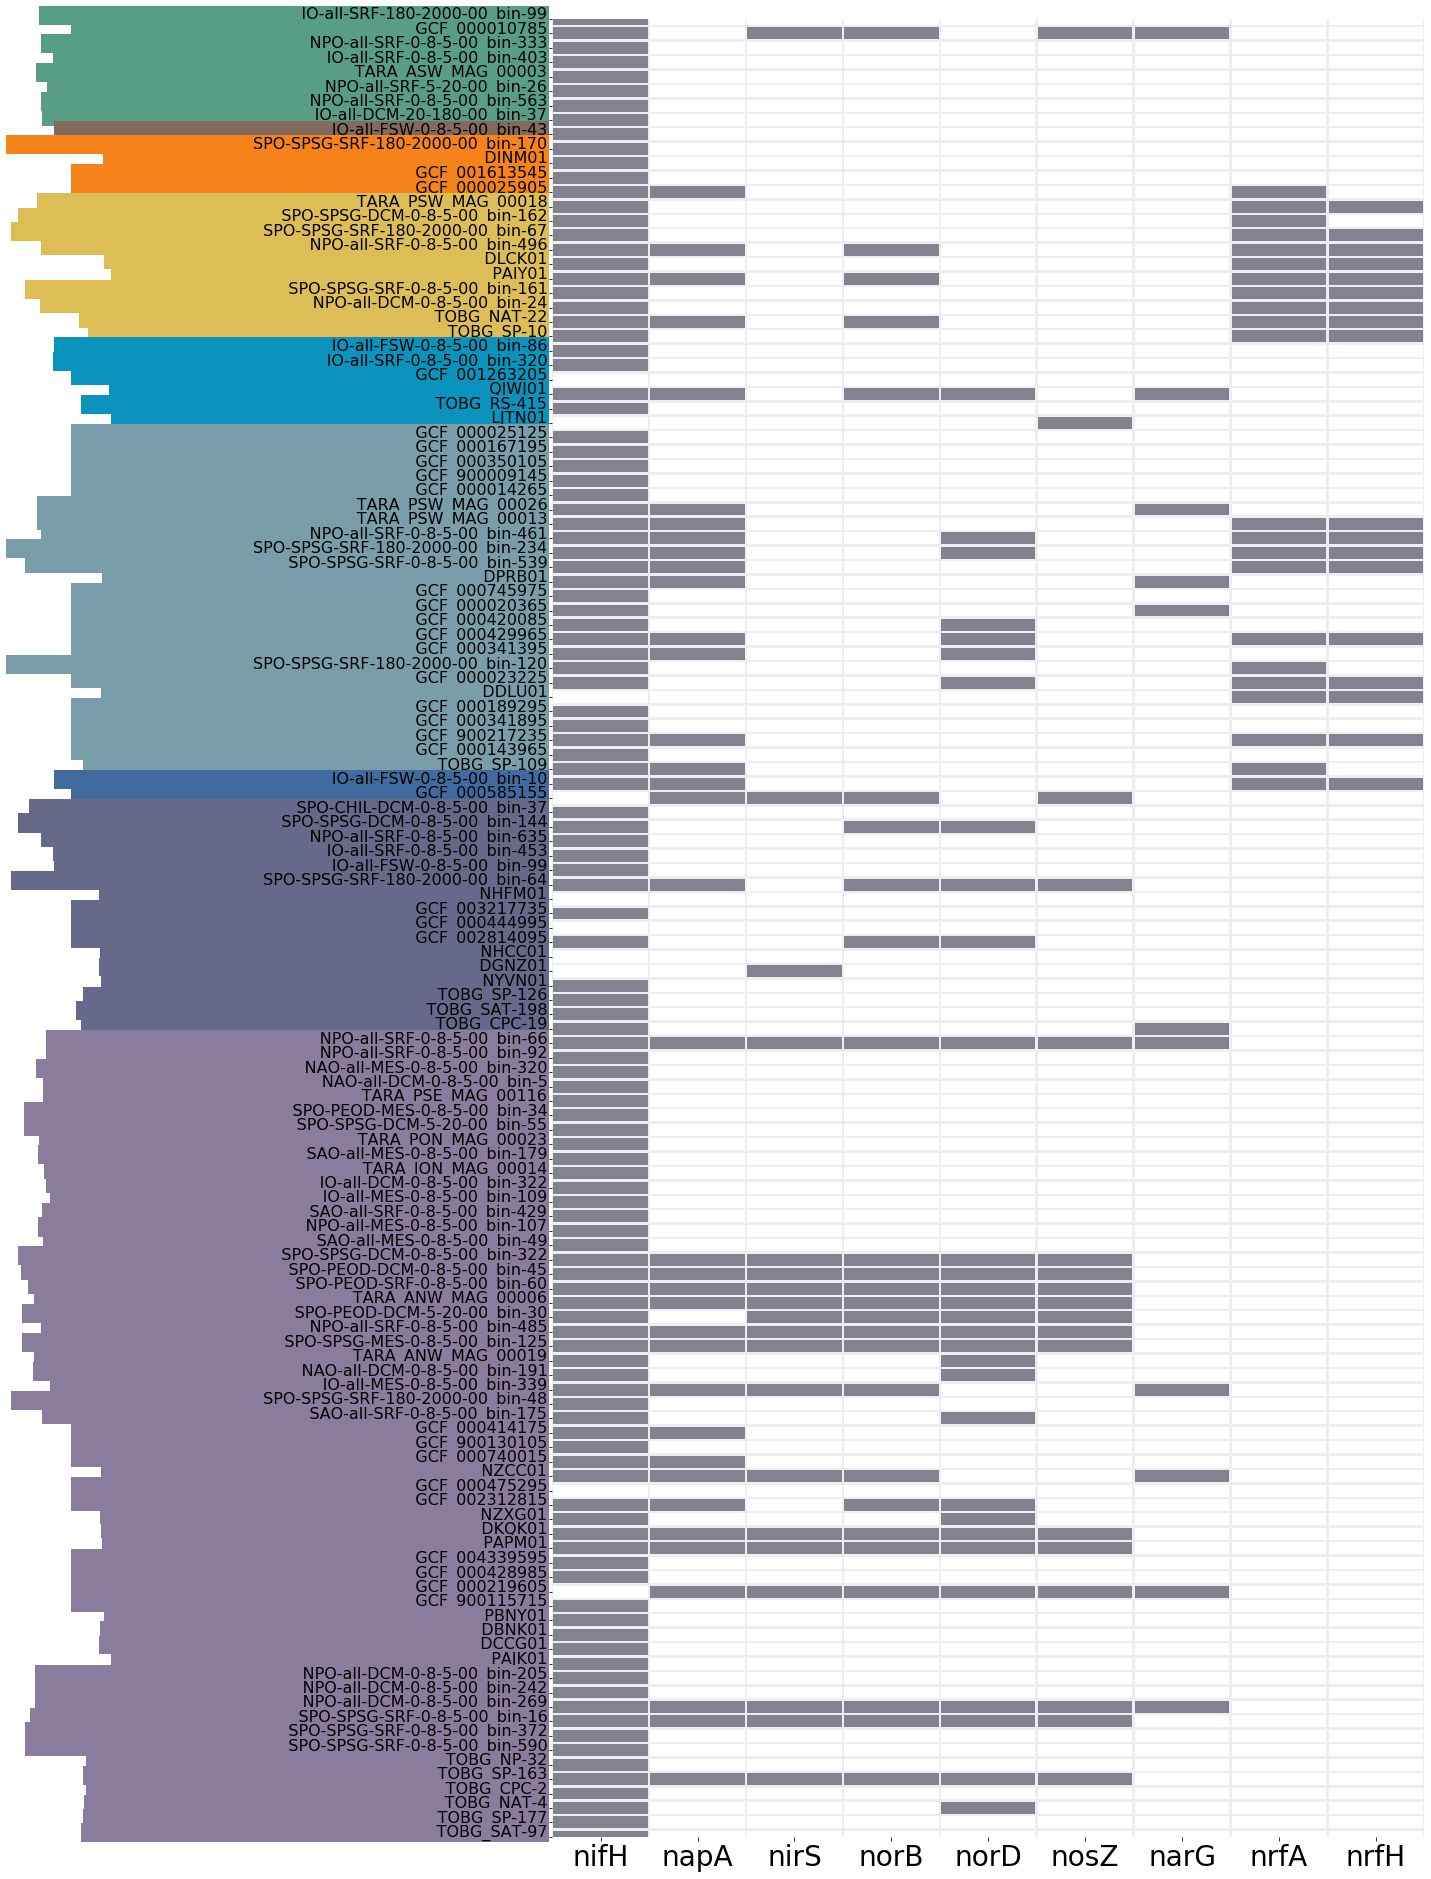

In [16]:
#Create a heatmap for nitrogen genes, with all MAGs and reference genomes
count_df = aggregate_counts
gene_df = nitrogen_genes
gene_list = gene_df['KEGG']
gene_counts = count_df.loc[count_df.index.isin(gene_list)]
gene_counts = gene_counts.T

#switch counts to presence absence 
gene_counts[gene_counts != 0] = 1

gene_counts = bin_file.merge(gene_counts, left_on= 'bin_name', right_index = True)


fig, ax = plt.subplots()
fig.set_size_inches([20,26.2])

heatmap_df = gene_counts.iloc[:,3:].reindex(columns = genes_of_interest)

g = sns.heatmap(heatmap_df,cbar=False,  
               cmap = ['white', '#83838f'], yticklabels=True, xticklabels=True, linewidths = 1.5, linecolor = "#EDEEF2", ax=ax)

        
xlabs = create_x_labs(heatmap_df)
g.set_xticklabels(xlabs,rotation=0, fontsize = 28)  
#g.set_yticklabels(gene_counts['bin_name'].astype(str), ha="right", rotation = 0, fontsize = 13)
#manually set below with colored boxes. use this if not creating clored boxes.

#To color labels
ylabs = create_y_labs(gene_counts) #list of colors for y labels
index = 0
for label in g.get_yticklabels():
    color = ylabs[index]
    label.set_color(color)
    index += 1

y_ticks = ax.get_yticks()
x_ticks = ax.get_xticks()

#manually creates y labels
for i, y_tick in enumerate(y_ticks[:]): 
    t= ax.text(x_ticks[0]-0.55, y_tick , " "*(80-len(gene_counts['bin_name'].values[i])) + gene_counts['bin_name'].values[i], #hack to make box wider
            fontsize = 16,ha = 'right', bbox={'fc':ylabs[i], 'pad': 1.5, 'edgecolor':'none'})   
    
plt.tight_layout()
#fig.savefig('/vortexfs1/omics/alexander/lblum/tara_gene_finder/mag_analysis/jupyter_notebooks/output_figures/nitrogen_gene_heatmap_colors_all_MAGs_reference.svg', bbox_inches='tight')